# King County - Polynomial Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Normalization
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from k_mean_cluster_util import k_mean_optimization

## Getting data ready
First We'll have some intuition on the data and set the "id" as index value. Also remove duplicate values.

In [2]:
df = pd.read_csv('./kc_house_data.csv')
df.set_index('id', inplace=True)
df = df[~df.index.duplicated(keep='first')]
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


From date which is an object, "str" in this dataset, we'll have to convert to date and take year and month which is important to our model.

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df = df.drop('date', axis=1)
prices = df['price']
df = df.drop('price', axis=1)
df['price'] = prices
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,221900.0
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,538000.0
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,180000.0
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,604000.0
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,510000.0


Have an intuition on what columns contain null values and what their Dtypes are

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21436 non-null  int64  
 1   bathrooms      21436 non-null  float64
 2   sqft_living    21436 non-null  int64  
 3   sqft_lot       21436 non-null  int64  
 4   floors         21436 non-null  float64
 5   waterfront     21436 non-null  int64  
 6   view           21436 non-null  int64  
 7   condition      21436 non-null  int64  
 8   grade          21436 non-null  int64  
 9   sqft_above     21436 non-null  int64  
 10  sqft_basement  21436 non-null  int64  
 11  yr_built       21436 non-null  int64  
 12  yr_renovated   21436 non-null  int64  
 13  zipcode        21436 non-null  int64  
 14  lat            21436 non-null  float64
 15  long           21436 non-null  float64
 16  sqft_living15  21436 non-null  int64  
 17  sqft_lot15     21436 non-null  int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,21436.0,3.371571,0.929205,0.0000,3.0000,3.000,4.000,3.300000e+01
bathrooms,21436.0,2.117349,0.769913,0.0000,1.7500,2.250,2.500,8.000000e+00
sqft_living,21436.0,2082.704936,919.146469,290.0000,1430.0000,1920.000,2550.000,1.354000e+04
sqft_lot,21436.0,15135.637852,41538.620606,520.0000,5040.0000,7614.000,10696.250,1.651359e+06
floors,21436.0,1.496198,0.540388,1.0000,1.0000,1.500,2.000,3.500000e+00
waterfront,21436.0,0.007604,0.086871,0.0000,0.0000,0.000,0.000,1.000000e+00
view,21436.0,0.235118,0.767092,0.0000,0.0000,0.000,0.000,4.000000e+00
condition,21436.0,3.410384,0.650235,1.0000,3.0000,3.000,4.000,5.000000e+00
grade,21436.0,7.661737,1.174256,1.0000,7.0000,7.000,8.000,1.300000e+01
sqft_above,21436.0,1790.960440,829.026491,290.0000,1200.0000,1560.000,2220.000,9.410000e+03


In [6]:
(df == 0).sum()

bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21273
view             19320
condition            0
grade                0
sqft_above           0
sqft_basement    13015
yr_built             0
yr_renovated     20526
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
year                 0
month                0
price                0
dtype: int64

Correlation of two values gives a great insight on what features impact the values of each other

In [7]:
df.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price
bedrooms,1.000000,0.516772,0.577512,0.031719,0.175207,-0.006685,0.079542,0.027896,0.358396,0.478441,...,0.153745,0.018435,-0.153621,-0.010228,0.129836,0.393161,0.029117,-0.010065,-0.000413,0.309007
bathrooms,0.516772,1.000000,0.754422,0.087143,0.499863,0.063734,0.186684,-0.127839,0.664727,0.684994,...,0.505092,0.051101,-0.202958,0.023444,0.221935,0.568194,0.086627,-0.023215,0.005427,0.525453
sqft_living,0.577512,0.754422,1.000000,0.171957,0.352867,0.103902,0.283753,-0.060973,0.762402,0.876683,...,0.316544,0.055084,-0.198621,0.051118,0.239214,0.756205,0.182775,-0.025818,0.010058,0.701993
sqft_lot,0.031719,0.087143,0.171957,1.000000,-0.005950,0.021571,0.075012,-0.009298,0.112541,0.182581,...,0.052447,0.007636,-0.129411,-0.085992,0.229555,0.143650,0.718097,0.005981,-0.002557,0.088895
floors,0.175207,0.499863,0.352867,-0.005950,1.000000,0.023473,0.028211,-0.266543,0.457475,0.522648,...,0.489062,0.005626,-0.058108,0.049279,0.124285,0.278854,-0.011917,-0.018709,0.011864,0.256278
waterfront,-0.006685,0.063734,0.103902,0.021571,0.023473,1.000000,0.403025,0.016607,0.082841,0.072021,...,-0.026537,0.093025,0.030558,-0.014395,-0.042188,0.086558,0.030694,-0.003444,0.007724,0.266961
view,0.079542,0.186684,0.283753,0.075012,0.028211,0.403025,1.000000,0.045051,0.249890,0.166930,...,-0.055153,0.103633,0.087096,0.005671,-0.079720,0.279077,0.072867,0.003066,-0.006918,0.396933
condition,0.027896,-0.127839,-0.060973,-0.009298,-0.266543,0.016607,0.045051,1.000000,-0.148248,-0.160782,...,-0.364947,-0.061136,0.004509,-0.015402,-0.107780,-0.095002,-0.003731,-0.044611,0.021396,0.035089
grade,0.358396,0.664727,0.762402,0.112541,0.457475,0.082841,0.249890,-0.148248,1.000000,0.756068,...,0.445329,0.014357,-0.182675,0.113332,0.196572,0.712507,0.118313,-0.025513,0.005161,0.667496
sqft_above,0.478441,0.684994,0.876683,0.182581,0.522648,0.072021,0.166930,-0.160782,0.756068,1.000000,...,0.422838,0.022666,-0.260420,-0.001652,0.343115,0.731992,0.193413,-0.020437,0.007820,0.605495


<AxesSubplot:>

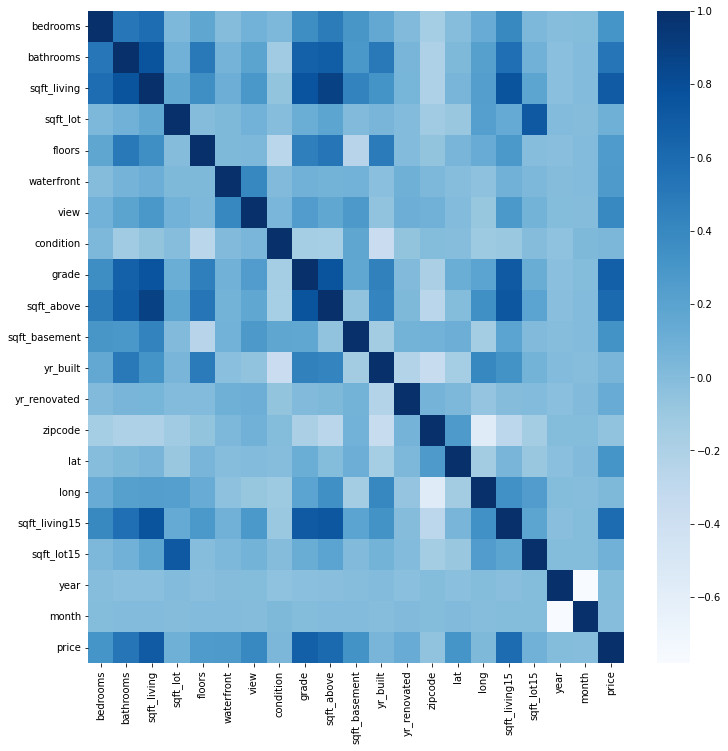

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap='Blues')

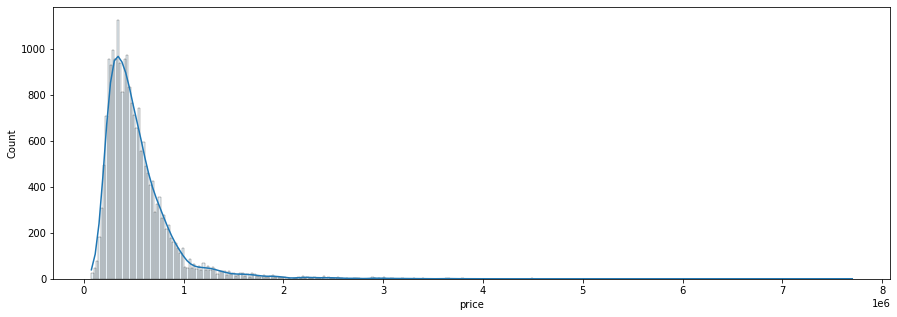

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='price'>

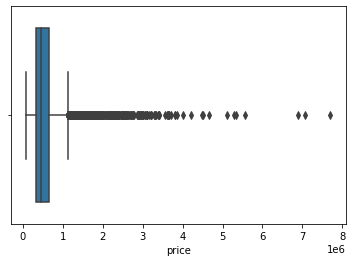

In [10]:
sns.boxplot(data=df, x='price')

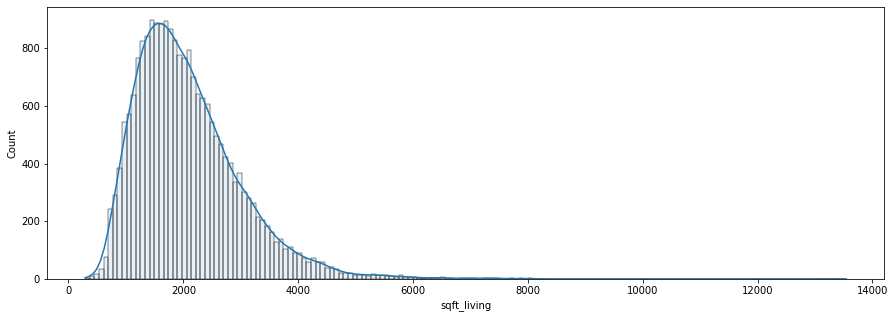

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

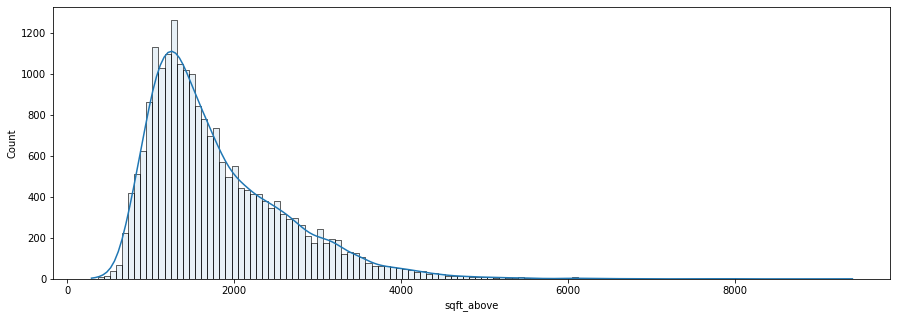

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_above', ax=ax, kde=True, alpha=0.1);

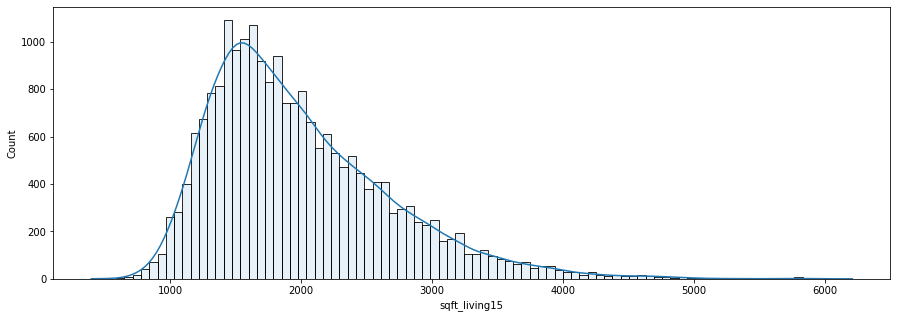

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

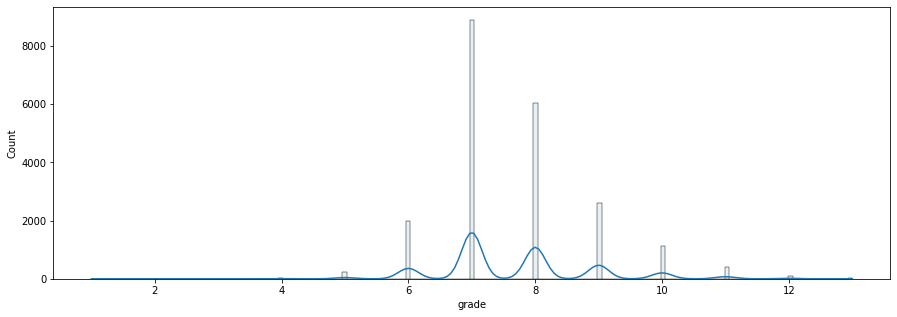

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='grade', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

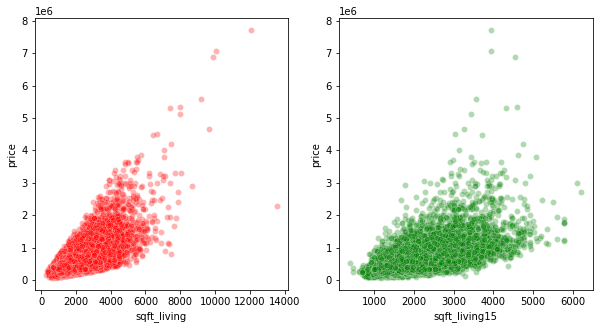

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

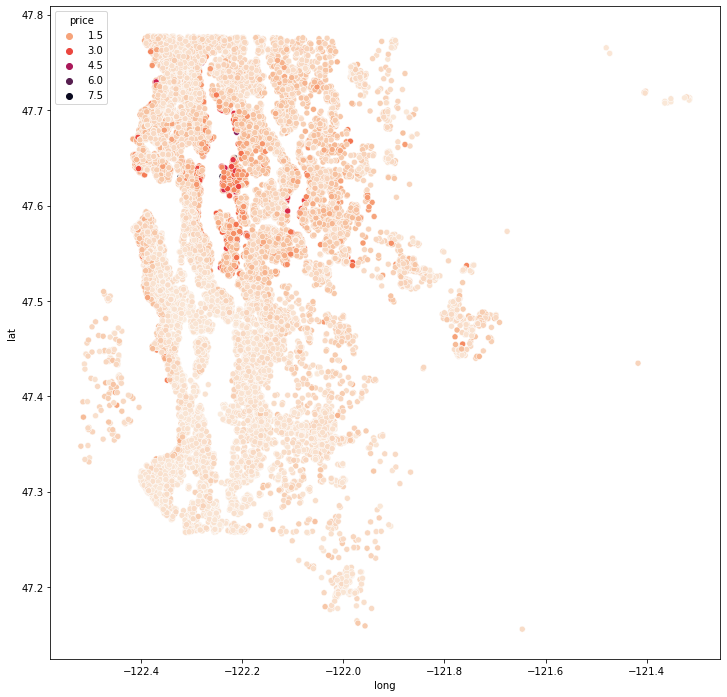

In [16]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

### Should we remove outliers?
For housing prices, a house could have been sold for a value less than what it worths. Or the house could've been sold more than what it worths. According to the red graph, some house with 13.5k sqft_living has been sold for about 2m dollars but some other house with about 12k sqft_living has been sold for about 7.5m dollars. This case could be seen as an outlier but there are other factors that have impact on the price.

In [17]:
df[df['sqft_living'] > 12000].T

id,6762700020,1225069038
bedrooms,6.000000e+00,7.000000e+00
bathrooms,8.000000e+00,8.000000e+00
sqft_living,1.205000e+04,1.354000e+04
sqft_lot,2.760000e+04,3.077520e+05
floors,2.500000e+00,3.000000e+00
waterfront,0.000000e+00,0.000000e+00
view,3.000000e+00,4.000000e+00
condition,4.000000e+00,3.000000e+00
grade,1.300000e+01,1.200000e+01
sqft_above,8.570000e+03,9.410000e+03


Two houses are somewhat the same and in the same area according to their lat and long. <br>
- More expensive one is older than the new one
- More expensive one's grade is greater than the other by 1 values
- sqft_lot15 is very large compared to the other one
- In 1987, the expensive house has been renovated but the other one hasn't been renovated
<br>
Other than these, the other house is better in every aspect. So why it is less expensive or not at all expensive? <br>
I'd say the first one is expensive because it is near the lake.

In [18]:
def remove_outliers(df, columns='all'):
    columns = df.columns if columns == 'all' else columns
    for c in columns:
        df = remove_columns_outlier(df, c)
    return df

def remove_columns_outlier(df, column):
    column = df[column]
    column_norm = (column - np.mean(column)) / np.std(column)
    column_norm = column_norm[~((column_norm >= 3) | (column_norm <= -3))]
    return df.loc[df.index[df.index.value_counts() == 1]]

def remove_outliers_per(df, column, per_column):
    fraction = column / per_column
    frac_norm = (fraction - np.mean(fraction)) / np.std(fraction)
    frac_norm = frac_norm[~((frac_norm >= 3) | (frac_norm <= -3))]
    return df.loc[list(frac_norm.index)]

def percentage_from_right(df, column, from_value):
    per = df[df[column] > from_value].size / df.size
    per = per * 100
    return per

def percentage_from_left(df, column, from_value):
    per = df[df[column] < from_value].size / df.size
    per = per * 100
    return per
    
def drop_tail_right(df, column, from_value, max_percentage=5):
    per = percentage_from_right(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] < from_value]

def drop_tail_left(df, column, from_value, max_percentage=5):
    per = percentage_from_left(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] > from_value]


def remove_outliers_IQR(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    res = drop_tail_right(df, column, q3 + 1.5 * IQR, 100)
    res = drop_tail_left(res, column, q1 - 1.5 * IQR, 100)
    per = percentage_from_right(df, column, q3 + 1.5 * IQR) + percentage_from_left(df, column, q1 - 1.5 * IQR)
    print(f'dropping {per:.2f}% data')
    return res

In [19]:
#df = remove_outliers(df, ['price'])
#df = remove_outliers_per(df, df['price'], df['sqft_living'])
#df = remove_outliers_per(df, df['price'], df['sqft_above'])
#df = remove_outliers_per(df, df['price'], df['sqft_living15'])

#df = drop_tail_right(df, 'price', 969000, 9)
#df = drop_tail_right(df, 'sqft_living', 3850, 3)
#df = drop_tail_right(df, 'sqft_living15', 3500, 3)
#df = drop_tail_left(df, 'grade', 5, 5)
#df = drop_tail_right(df, 'grade', 11, 5)

df = remove_outliers_IQR(df, 'price')
#df = remove_outliers_IQR(df, 'sqft_living')
#df = df.drop('sqft_above', axis=1)

dropping 5.31% data


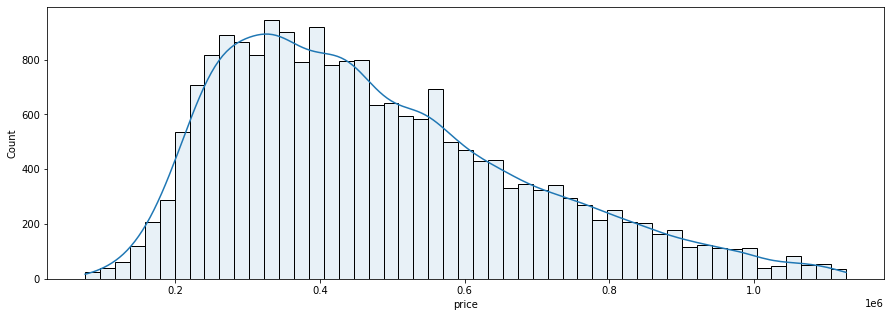

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

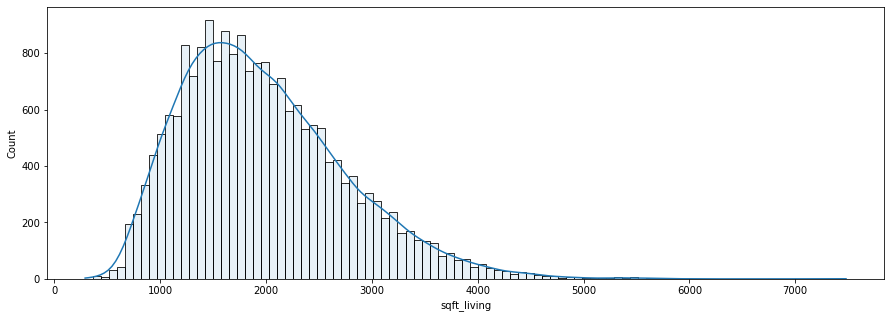

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

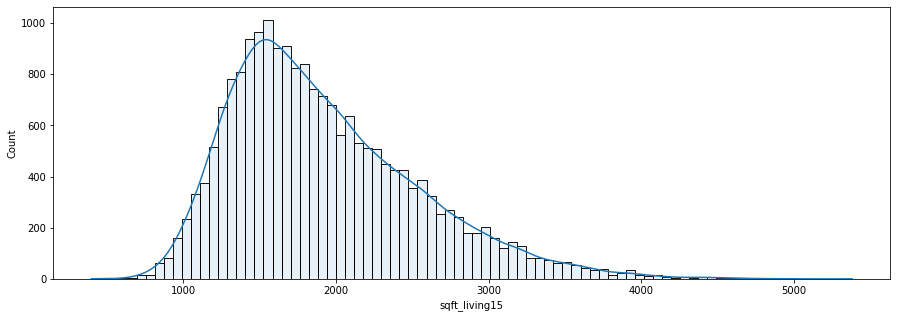

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

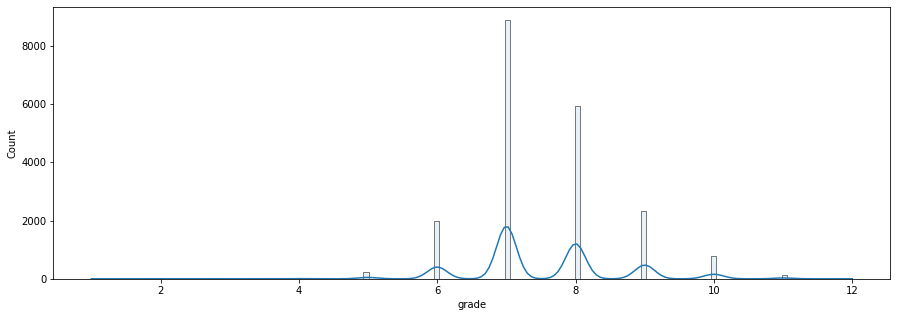

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='grade', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

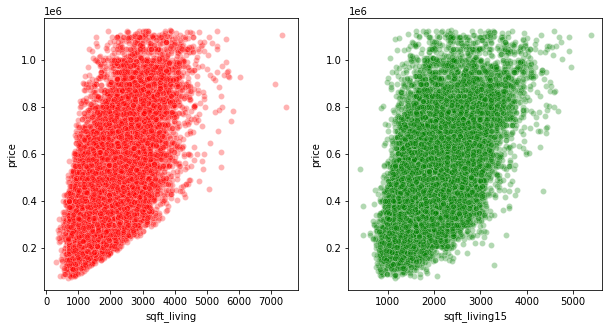

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

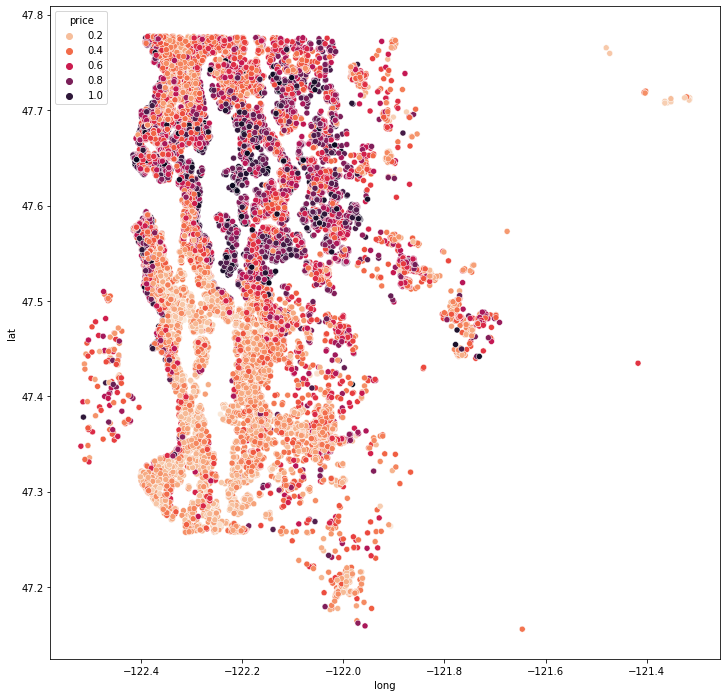

In [25]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

As it seems some regions here, have expensive houses, So we'll try to cluster each region.<br>
We'll use "lat" and "long" and "price" to cluster each using K_mean clustering algorithm.

In [26]:
selected = df[['lat', 'long', 'price']]
ids = selected.index.values
selected = selected.values
selected.shape

(20297, 3)

In [27]:
centeroids, idx = k_mean_optimization(selected, 10, 30, 25)

Iteration 1/25
Distortion: 729276054.9152492
Iteration 2/25
Distortion: 715721258.5721724
Iteration 3/25
Distortion: 814310527.0863787
Iteration 4/25
Distortion: 715581725.1832263
Iteration 5/25
Distortion: 812854337.6626717
Iteration 6/25
Distortion: 725115505.5708458
Iteration 7/25
Distortion: 715986180.3516777
Iteration 8/25
Distortion: 696839588.6763926
Iteration 9/25
Distortion: 777175060.8963965
Iteration 10/25
Distortion: 766833469.3737375
Iteration 11/25
Distortion: 719721382.4357355
Iteration 12/25
Distortion: 691929551.8689798
Iteration 13/25
Distortion: 719421720.802529
Iteration 14/25
Distortion: 701788784.4559438
Iteration 15/25
Distortion: 738547949.870007
Iteration 16/25
Distortion: 695067248.6682335
Iteration 17/25
Distortion: 810350044.6137305
Iteration 18/25
Distortion: 771300091.2360948
Iteration 19/25
Distortion: 839667499.2551008
Iteration 20/25
Distortion: 813562971.7778429
Iteration 21/25
Distortion: 731457181.4354339
Iteration 22/25
Distortion: 749133814.5489012

In [28]:
selected = np.c_[ids, selected, idx]
selected = pd.DataFrame(selected, columns=['id', 'lat', 'long', 'price', 'cluster'])
selected

,id,lat,long,price,cluster
0,7.129301e+09,47.5112,-122.257,221900.0,2.0
1,6.414100e+09,47.7210,-122.319,538000.0,4.0
2,5.631500e+09,47.7379,-122.233,180000.0,2.0
3,2.487201e+09,47.5208,-122.393,604000.0,4.0
4,1.954401e+09,47.6168,-122.045,510000.0,1.0
...,...,...,...,...,...
20292,2.630000e+08,47.6993,-122.346,360000.0,0.0
20293,6.600060e+09,47.5107,-122.362,400000.0,6.0
20294,1.523300e+09,47.5944,-122.299,402101.0,6.0
20295,2.913101e+08,47.5345,-122.069,400000.0,6.0


In [29]:
selected.set_index('id', inplace=True)
selected

,lat,long,price,cluster
id,,,,
7.129301e+09,47.5112,-122.257,221900.0,2.0
6.414100e+09,47.7210,-122.319,538000.0,4.0
5.631500e+09,47.7379,-122.233,180000.0,2.0
2.487201e+09,47.5208,-122.393,604000.0,4.0
1.954401e+09,47.6168,-122.045,510000.0,1.0
...,...,...,...,...
2.630000e+08,47.6993,-122.346,360000.0,0.0
6.600060e+09,47.5107,-122.362,400000.0,6.0
1.523300e+09,47.5944,-122.299,402101.0,6.0


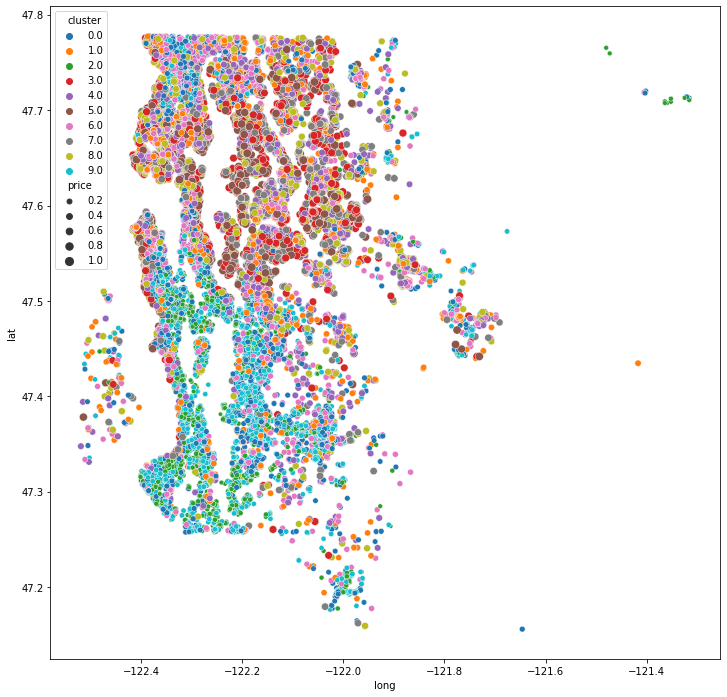

In [30]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=selected, x='long', y='lat', hue='cluster', palette='tab10', size='price');

In [31]:
clusters = pd.get_dummies(data=selected.cluster, drop_first=True, prefix='cluster')
df = pd.concat([df, clusters], axis=1)

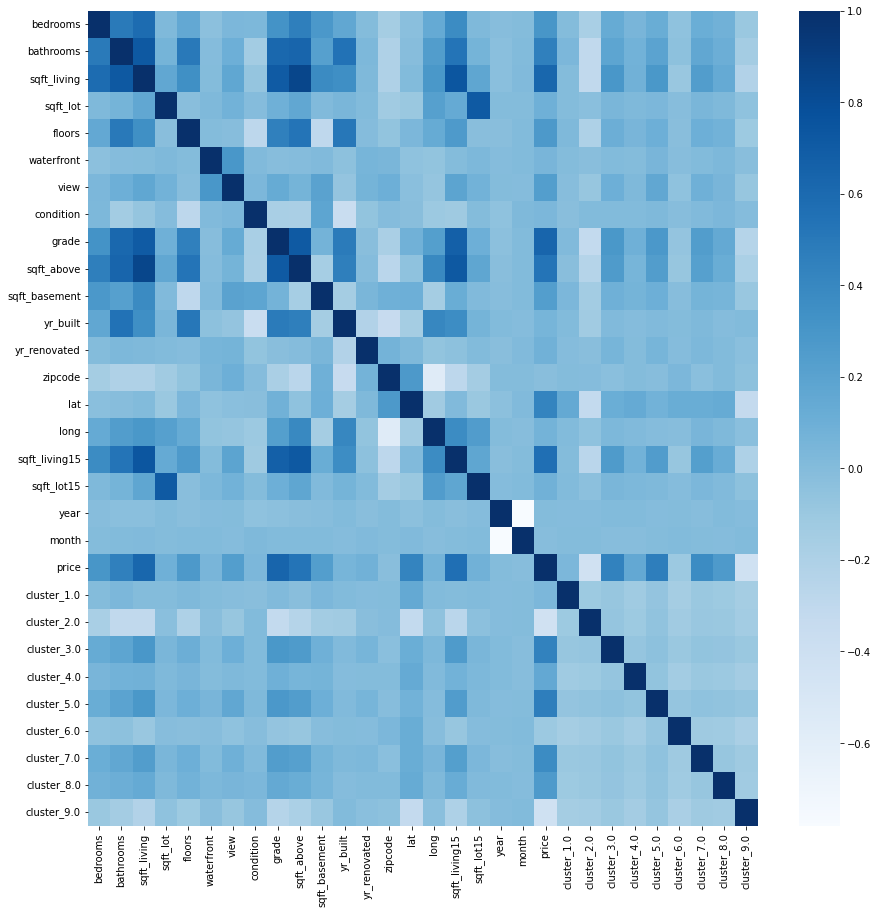

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cmap='Blues');

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,20297.0,3.330246,0.911846,0.0000,3.0000,3.0000,4.0000,3.300000e+01
bathrooms,20297.0,2.054084,0.711399,0.0000,1.5000,2.0000,2.5000,7.500000e+00
sqft_living,20297.0,1978.235158,775.491728,290.0000,1400.0000,1860.0000,2440.0000,7.480000e+03
sqft_lot,20297.0,14646.335173,40247.208902,520.0000,5000.0000,7500.0000,10321.0000,1.651359e+06
floors,20297.0,1.477854,0.537484,1.0000,1.0000,1.0000,2.0000,3.500000e+00
waterfront,20297.0,0.003005,0.054740,0.0000,0.0000,0.0000,0.0000,1.000000e+00
view,20297.0,0.173622,0.642417,0.0000,0.0000,0.0000,0.0000,4.000000e+00
condition,20297.0,3.407499,0.646790,1.0000,3.0000,3.0000,4.0000,5.000000e+00
grade,20297.0,7.535498,1.038258,1.0000,7.0000,7.0000,8.0000,1.200000e+01
sqft_above,20297.0,1710.736562,728.055167,290.0000,1180.0000,1520.0000,2110.0000,5.710000e+03


## Getting Data ready for trainning

In [34]:
X_train = df.drop(['price'], axis=1).values
y_train = df['price'].values

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly = poly.fit(X_train)
X_train = poly.transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=123)
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

In [35]:
print(f'X_train shape is {X_train.shape} and y_train shape is {y_train.shape}')
print(f'y_cv shape is {X_cv.shape} and y_cv shape is {y_cv.shape}')
print(f'X_test shape is {X_test.shape} and y_test shape is {y_test.shape}')

X_train shape is (16237, 464) and y_train shape is (16237,)
y_cv shape is (2030, 464) and y_cv shape is (2030,)
X_test shape is (2030, 464) and y_test shape is (2030,)


### Normalize the data

In [36]:
norm = Normalization()
norm.adapt(X_train)
Xn_train = norm(X_train)
Xn_cv = norm(X_cv)
Xn_test = norm(X_test)

## Training

In [37]:
model = SGDRegressor(max_iter=100000, verbose=True, eta0=0.0001, tol=1e-5)
model = model.fit(Xn_train, y_train)

-- Epoch 1
Norm: 38916.67, NNZs: 427, Bias: 83299.493575, T: 16237, Avg. loss: 95619684712.289001
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 43311.27, NNZs: 427, Bias: 131682.438313, T: 32474, Avg. loss: 69552169622.341583
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 45867.77, NNZs: 427, Bias: 169182.280200, T: 48711, Avg. loss: 54401247806.130104
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 48372.43, NNZs: 427, Bias: 200023.618741, T: 64948, Avg. loss: 43675493713.211334
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 49972.21, NNZs: 427, Bias: 226161.253740, T: 81185, Avg. loss: 35640063938.343491
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 51450.55, NNZs: 427, Bias: 248725.523801, T: 97422, Avg. loss: 29436682652.901829
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 52449.81, NNZs: 427, Bias: 268461.682161, T: 113659, Avg. loss: 24535544113.424297
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 53478.02, NNZs: 427, Bias: 285887.153215, T: 

Norm: 62788.70, NNZs: 427, Bias: 471974.677196, T: 1071642, Avg. loss: 379407255.343006
Total training time: 1.23 seconds.
-- Epoch 67
Norm: 62837.20, NNZs: 427, Bias: 472250.518796, T: 1087879, Avg. loss: 377497960.248750
Total training time: 1.25 seconds.
-- Epoch 68
Norm: 62875.36, NNZs: 427, Bias: 472512.207416, T: 1104116, Avg. loss: 375779122.175556
Total training time: 1.27 seconds.
-- Epoch 69
Norm: 62898.44, NNZs: 427, Bias: 472759.603042, T: 1120353, Avg. loss: 374135101.089997
Total training time: 1.29 seconds.
-- Epoch 70
Norm: 62954.91, NNZs: 427, Bias: 472994.644300, T: 1136590, Avg. loss: 372701833.938609
Total training time: 1.31 seconds.
-- Epoch 71
Norm: 63010.47, NNZs: 427, Bias: 473217.401048, T: 1152827, Avg. loss: 371294777.052437
Total training time: 1.33 seconds.
-- Epoch 72
Norm: 63037.06, NNZs: 427, Bias: 473428.540357, T: 1169064, Avg. loss: 370110116.538392
Total training time: 1.35 seconds.
-- Epoch 73
Norm: 63062.95, NNZs: 427, Bias: 473628.666890, T: 1185

Norm: 64843.39, NNZs: 427, Bias: 477369.736415, T: 2224469, Avg. loss: 349181157.411487
Total training time: 2.49 seconds.
-- Epoch 138
Norm: 64878.01, NNZs: 427, Bias: 477378.752567, T: 2240706, Avg. loss: 349020902.791597
Total training time: 2.51 seconds.
-- Epoch 139
Norm: 64879.87, NNZs: 427, Bias: 477387.260560, T: 2256943, Avg. loss: 348924600.539164
Total training time: 2.52 seconds.
-- Epoch 140
Norm: 64917.09, NNZs: 427, Bias: 477395.565511, T: 2273180, Avg. loss: 348831925.047077
Total training time: 2.54 seconds.
-- Epoch 141
Norm: 64931.13, NNZs: 427, Bias: 477403.497505, T: 2289417, Avg. loss: 348699353.227950
Total training time: 2.56 seconds.
-- Epoch 142
Norm: 64954.95, NNZs: 427, Bias: 477410.940346, T: 2305654, Avg. loss: 348587763.633706
Total training time: 2.58 seconds.
-- Epoch 143
Norm: 64978.20, NNZs: 427, Bias: 477418.294429, T: 2321891, Avg. loss: 348497321.918688
Total training time: 2.59 seconds.
-- Epoch 144
Norm: 65007.75, NNZs: 427, Bias: 477425.393161, 

Norm: 66276.03, NNZs: 427, Bias: 477576.641994, T: 3393533, Avg. loss: 342763226.719072
Total training time: 3.77 seconds.
-- Epoch 210
Norm: 66283.22, NNZs: 427, Bias: 477577.147072, T: 3409770, Avg. loss: 342680155.006809
Total training time: 3.79 seconds.
-- Epoch 211
Norm: 66312.23, NNZs: 427, Bias: 477577.543414, T: 3426007, Avg. loss: 342643709.435729
Total training time: 3.81 seconds.
-- Epoch 212
Norm: 66328.76, NNZs: 427, Bias: 477578.031209, T: 3442244, Avg. loss: 342571928.399529
Total training time: 3.82 seconds.
-- Epoch 213
Norm: 66347.32, NNZs: 427, Bias: 477578.471635, T: 3458481, Avg. loss: 342518861.102362
Total training time: 3.84 seconds.
-- Epoch 214
Norm: 66366.92, NNZs: 427, Bias: 477578.829202, T: 3474718, Avg. loss: 342438214.250298
Total training time: 3.86 seconds.
-- Epoch 215
Norm: 66380.05, NNZs: 427, Bias: 477579.377380, T: 3490955, Avg. loss: 342364274.240100
Total training time: 3.88 seconds.
-- Epoch 216
Norm: 66397.57, NNZs: 427, Bias: 477579.810602, 

Norm: 67394.67, NNZs: 427, Bias: 477588.499944, T: 4546360, Avg. loss: 338916140.920680
Total training time: 5.05 seconds.
-- Epoch 281
Norm: 67404.00, NNZs: 427, Bias: 477588.455628, T: 4562597, Avg. loss: 338893337.561070
Total training time: 5.07 seconds.
-- Epoch 282
Norm: 67413.99, NNZs: 427, Bias: 477588.442911, T: 4578834, Avg. loss: 338850688.718153
Total training time: 5.09 seconds.
-- Epoch 283
Norm: 67434.85, NNZs: 427, Bias: 477588.523341, T: 4595071, Avg. loss: 338813762.457703
Total training time: 5.10 seconds.
-- Epoch 284
Norm: 67432.85, NNZs: 427, Bias: 477588.527306, T: 4611308, Avg. loss: 338700505.971553
Total training time: 5.12 seconds.
-- Epoch 285
Norm: 67456.22, NNZs: 427, Bias: 477588.636545, T: 4627545, Avg. loss: 338737652.998405
Total training time: 5.14 seconds.
-- Epoch 286
Norm: 67466.00, NNZs: 427, Bias: 477588.695704, T: 4643782, Avg. loss: 338665294.471991
Total training time: 5.16 seconds.
-- Epoch 287
Norm: 67494.49, NNZs: 427, Bias: 477588.847663, 

Norm: 68265.99, NNZs: 427, Bias: 477589.003228, T: 5634239, Avg. loss: 336424449.971592
Total training time: 6.29 seconds.
-- Epoch 348
Norm: 68276.06, NNZs: 427, Bias: 477588.918341, T: 5650476, Avg. loss: 336386642.134561
Total training time: 6.31 seconds.
-- Epoch 349
Norm: 68291.43, NNZs: 427, Bias: 477588.977895, T: 5666713, Avg. loss: 336344648.329838
Total training time: 6.33 seconds.
-- Epoch 350
Norm: 68308.51, NNZs: 427, Bias: 477588.984465, T: 5682950, Avg. loss: 336313323.893648
Total training time: 6.35 seconds.
-- Epoch 351
Norm: 68314.71, NNZs: 427, Bias: 477589.029047, T: 5699187, Avg. loss: 336280073.541758
Total training time: 6.36 seconds.
-- Epoch 352
Norm: 68330.07, NNZs: 427, Bias: 477589.002463, T: 5715424, Avg. loss: 336262748.799846
Total training time: 6.38 seconds.
-- Epoch 353
Norm: 68347.97, NNZs: 427, Bias: 477588.961301, T: 5731661, Avg. loss: 336208821.540332
Total training time: 6.40 seconds.
-- Epoch 354
Norm: 68349.44, NNZs: 427, Bias: 477588.901947, 

Norm: 69058.61, NNZs: 427, Bias: 477589.391957, T: 6754592, Avg. loss: 334473844.542745
Total training time: 7.55 seconds.
-- Epoch 417
Norm: 69064.63, NNZs: 427, Bias: 477589.478470, T: 6770829, Avg. loss: 334450900.968287
Total training time: 7.57 seconds.
-- Epoch 418
Norm: 69084.40, NNZs: 427, Bias: 477589.495775, T: 6787066, Avg. loss: 334411791.039899
Total training time: 7.58 seconds.
-- Epoch 419
Norm: 69096.20, NNZs: 427, Bias: 477589.435089, T: 6803303, Avg. loss: 334399813.670256
Total training time: 7.60 seconds.
-- Epoch 420
Norm: 69096.05, NNZs: 427, Bias: 477589.378787, T: 6819540, Avg. loss: 334364253.782316
Total training time: 7.62 seconds.
-- Epoch 421
Norm: 69114.59, NNZs: 427, Bias: 477589.510732, T: 6835777, Avg. loss: 334352811.968675
Total training time: 7.64 seconds.
-- Epoch 422
Norm: 69119.33, NNZs: 427, Bias: 477589.540885, T: 6852014, Avg. loss: 334331246.793658
Total training time: 7.65 seconds.
-- Epoch 423
Norm: 69138.40, NNZs: 427, Bias: 477589.577628, 

Norm: 69746.01, NNZs: 427, Bias: 477589.313882, T: 7858708, Avg. loss: 332991841.631016
Total training time: 8.80 seconds.
-- Epoch 485
Norm: 69750.62, NNZs: 427, Bias: 477589.265895, T: 7874945, Avg. loss: 332965283.433608
Total training time: 8.82 seconds.
-- Epoch 486
Norm: 69758.08, NNZs: 427, Bias: 477589.250310, T: 7891182, Avg. loss: 332948367.162607
Total training time: 8.84 seconds.
-- Epoch 487
Norm: 69777.23, NNZs: 427, Bias: 477589.331914, T: 7907419, Avg. loss: 332928321.434819
Total training time: 8.86 seconds.
-- Epoch 488
Norm: 69781.68, NNZs: 427, Bias: 477589.347057, T: 7923656, Avg. loss: 332919361.013604
Total training time: 8.88 seconds.
-- Epoch 489
Norm: 69791.44, NNZs: 427, Bias: 477589.385856, T: 7939893, Avg. loss: 332900162.523773
Total training time: 8.90 seconds.
-- Epoch 490
Norm: 69795.60, NNZs: 427, Bias: 477589.418121, T: 7956130, Avg. loss: 332872115.388313
Total training time: 8.91 seconds.
-- Epoch 491
Norm: 69805.58, NNZs: 427, Bias: 477589.497050, 

Norm: 70359.53, NNZs: 427, Bias: 477589.675730, T: 8962824, Avg. loss: 331774182.321248
Total training time: 10.06 seconds.
-- Epoch 553
Norm: 70372.33, NNZs: 427, Bias: 477589.714523, T: 8979061, Avg. loss: 331770003.804649
Total training time: 10.08 seconds.
-- Epoch 554
Norm: 70368.11, NNZs: 427, Bias: 477589.550976, T: 8995298, Avg. loss: 331725470.773988
Total training time: 10.10 seconds.
-- Epoch 555
Norm: 70385.22, NNZs: 427, Bias: 477589.440569, T: 9011535, Avg. loss: 331742933.063919
Total training time: 10.12 seconds.
-- Epoch 556
Norm: 70393.78, NNZs: 427, Bias: 477589.481259, T: 9027772, Avg. loss: 331724947.357117
Total training time: 10.14 seconds.
-- Epoch 557
Norm: 70398.47, NNZs: 427, Bias: 477589.526138, T: 9044009, Avg. loss: 331693124.098983
Total training time: 10.16 seconds.
-- Epoch 558
Norm: 70412.49, NNZs: 427, Bias: 477589.502605, T: 9060246, Avg. loss: 331690722.591486
Total training time: 10.18 seconds.
-- Epoch 559
Norm: 70415.42, NNZs: 427, Bias: 477589.4

Norm: 70907.82, NNZs: 427, Bias: 477589.521384, T: 10034466, Avg. loss: 330817052.804653
Total training time: 11.32 seconds.
-- Epoch 619
Norm: 70920.16, NNZs: 427, Bias: 477589.638016, T: 10050703, Avg. loss: 330805588.537619
Total training time: 11.33 seconds.
-- Epoch 620
Norm: 70920.00, NNZs: 427, Bias: 477589.525077, T: 10066940, Avg. loss: 330778982.634802
Total training time: 11.35 seconds.
-- Epoch 621
Norm: 70924.27, NNZs: 427, Bias: 477589.413177, T: 10083177, Avg. loss: 330772727.007438
Total training time: 11.37 seconds.
-- Epoch 622
Norm: 70931.87, NNZs: 427, Bias: 477589.455570, T: 10099414, Avg. loss: 330770746.372058
Total training time: 11.39 seconds.
-- Epoch 623
Norm: 70944.83, NNZs: 427, Bias: 477589.369293, T: 10115651, Avg. loss: 330757322.866596
Total training time: 11.40 seconds.
-- Epoch 624
Norm: 70950.45, NNZs: 427, Bias: 477589.314292, T: 10131888, Avg. loss: 330745751.537607
Total training time: 11.42 seconds.
-- Epoch 625
Norm: 70951.99, NNZs: 427, Bias: 4

Norm: 71434.40, NNZs: 427, Bias: 477589.507436, T: 11171056, Avg. loss: 329967814.200504
Total training time: 12.58 seconds.
-- Epoch 689
Norm: 71446.17, NNZs: 427, Bias: 477589.646133, T: 11187293, Avg. loss: 329917005.720712
Total training time: 12.60 seconds.
-- Epoch 690
Norm: 71446.97, NNZs: 427, Bias: 477589.618815, T: 11203530, Avg. loss: 329931717.014198
Total training time: 12.62 seconds.
-- Epoch 691
Norm: 71453.99, NNZs: 427, Bias: 477589.549723, T: 11219767, Avg. loss: 329920756.298135
Total training time: 12.63 seconds.
-- Epoch 692
Norm: 71463.75, NNZs: 427, Bias: 477589.543170, T: 11236004, Avg. loss: 329910598.136505
Total training time: 12.65 seconds.
-- Epoch 693
Norm: 71467.53, NNZs: 427, Bias: 477589.561630, T: 11252241, Avg. loss: 329901877.239090
Total training time: 12.67 seconds.
-- Epoch 694
Norm: 71475.23, NNZs: 427, Bias: 477589.555016, T: 11268478, Avg. loss: 329893081.554538
Total training time: 12.68 seconds.
-- Epoch 695
Norm: 71481.84, NNZs: 427, Bias: 4

In [38]:
J_abs_train = mean_absolute_error(y_train, model.predict(Xn_train))
J_abs_cv = mean_absolute_error(y_cv, model.predict(Xn_cv))
J_abs_test = mean_absolute_error(y_test, model.predict(Xn_test))

print(f'Absolute error for training set is {J_abs_train}')
print(f'Absolute error for cross validation set is {J_abs_cv}')
print(f'Absolute error for test set is {J_abs_test}')

Absolute error for training set is 21043.66007593401
Absolute error for cross validation set is 21314.318015794575
Absolute error for test set is 21033.362613787096


In [39]:
X_all = df.drop(['price'], axis=1).values
X_all = poly.transform(X_all)
Xn_all = norm(X_all)
p_df = df.copy(deep=True)
p_df['Predicted'] = model.predict(Xn_all).astype('int64')
p_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,cluster_1.0,cluster_2.0,cluster_3.0,cluster_4.0,cluster_5.0,cluster_6.0,cluster_7.0,cluster_8.0,cluster_9.0,Predicted
id,,,,,,,,,,,,,,,,,,,,,
7.129301e+09,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,0,1,0,0,0,0,0,0,0,197742
6.414100e+09,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,0,0,0,1,0,0,0,0,0,575434
5.631500e+09,2,1.00,770,10000,1.0,0,0,3,6,770,...,0,1,0,0,0,0,0,0,0,188597
2.487201e+09,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,0,0,0,1,0,0,0,0,0,567324
1.954401e+09,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1,0,0,0,0,0,0,0,0,496335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.630000e+08,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,0,0,0,0,0,0,0,0,0,354600
6.600060e+09,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,0,0,0,0,0,1,0,0,0,425272
1.523300e+09,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,0,0,0,0,0,1,0,0,0,412684


In [40]:
p_df.to_csv('output_PL.csv', index=True)